# **Checkpointing and Transfer Learning**


### **Implementing CNN for Dogs and Cats classification using Keras API**

In [ ]:
import os
import tensorflow as tf
import zipfile
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2023-04-04 07:12:45--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   143MB/s    in 0.5s    

2023-04-04 07:12:46 (143 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


### **2:  Design the CNN Architecture** 


In [ ]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64,(3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128,(3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128,(3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
opt = RMSprop(learning_rate=0.0001)
model.compile(optimizer=opt, loss = 'binary_crossentropy', metrics='acc')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150,150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150,150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### **Checkpointing**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir /tmp/weights

In [ ]:
## Adding checkpoints after every 2-epochs
filepath='/tmp/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

### **Training**

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=10,
      callbacks = [checkpoint],
      verbose=2)

Epoch 1/10
100/100 - 7s - loss: 0.4645 - acc: 0.7765 - val_loss: 0.5384 - val_acc: 0.7000 - 7s/epoch - 71ms/step
Epoch 2/10
100/100 - 8s - loss: 0.4421 - acc: 0.7885 - val_loss: 0.5599 - val_acc: 0.6850 - 8s/epoch - 82ms/step
Epoch 3/10
100/100 - 7s - loss: 0.4226 - acc: 0.8150 - val_loss: 0.5863 - val_acc: 0.6950 - 7s/epoch - 69ms/step
Epoch 4/10
100/100 - 8s - loss: 0.4012 - acc: 0.8325 - val_loss: 0.5924 - val_acc: 0.7050 - 8s/epoch - 79ms/step
Epoch 5/10
100/100 - 7s - loss: 0.3791 - acc: 0.8325 - val_loss: 0.7103 - val_acc: 0.6400 - 7s/epoch - 73ms/step
Epoch 6/10
100/100 - 7s - loss: 0.3543 - acc: 0.8430 - val_loss: 0.5809 - val_acc: 0.7100 - 7s/epoch - 73ms/step
Epoch 7/10
100/100 - 8s - loss: 0.3359 - acc: 0.8615 - val_loss: 0.6019 - val_acc: 0.7350 - 8s/epoch - 81ms/step
Epoch 8/10
100/100 - 7s - loss: 0.3164 - acc: 0.8720 - val_loss: 0.5860 - val_acc: 0.7350 - 7s/epoch - 67ms/step
Epoch 9/10
100/100 - 7s - loss: 0.2920 - acc: 0.8785 - val_loss: 0.5751 - val_acc: 0.6950 - 7s/e

### **Retraining from saved model**

In [ ]:
model_modify=tf.keras.models.load_model("/tmp/weights.10-0.52.hdf5")

In [ ]:
opti = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.0001)
model_modify.compile(optimizer = opti, loss = "binary_crossentropy", metrics = "acc")

model_modify.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150,150), 
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150,150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
## Adding checkpoints after every 2-epochs 
filepath='/tmp/weights_modified/w.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

In [ ]:
history = model_modify.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=10,
      callbacks = [checkpoint],
      verbose=2)

Epoch 1/10
100/100 - 8s - loss: 0.2591 - acc: 0.8920 - val_loss: 0.5638 - val_acc: 0.7850 - 8s/epoch - 82ms/step
Epoch 2/10
100/100 - 7s - loss: 0.2261 - acc: 0.9185 - val_loss: 0.5859 - val_acc: 0.7300 - 7s/epoch - 66ms/step
Epoch 3/10
100/100 - 7s - loss: 0.2072 - acc: 0.9210 - val_loss: 0.5754 - val_acc: 0.7400 - 7s/epoch - 68ms/step
Epoch 4/10
100/100 - 8s - loss: 0.1843 - acc: 0.9315 - val_loss: 0.4792 - val_acc: 0.7750 - 8s/epoch - 80ms/step
Epoch 5/10
100/100 - 6s - loss: 0.1572 - acc: 0.9485 - val_loss: 0.6974 - val_acc: 0.7500 - 6s/epoch - 64ms/step
Epoch 6/10
100/100 - 8s - loss: 0.1398 - acc: 0.9550 - val_loss: 0.7399 - val_acc: 0.7050 - 8s/epoch - 79ms/step
Epoch 7/10
100/100 - 8s - loss: 0.1243 - acc: 0.9570 - val_loss: 0.7708 - val_acc: 0.7050 - 8s/epoch - 79ms/step
Epoch 8/10
100/100 - 6s - loss: 0.1061 - acc: 0.9695 - val_loss: 0.9016 - val_acc: 0.7450 - 6s/epoch - 65ms/step
Epoch 9/10
100/100 - 8s - loss: 0.0976 - acc: 0.9735 - val_loss: 0.7496 - val_acc: 0.7450 - 8s/e

## **Transfer Learning**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#%cd /content/gdrive/MyDrive/42028/Week7/images

unzip:  cannot find or open images.zip, images.zip.zip or images.zip.ZIP.
/content/gdrive/MyDrive/42028/Week7/images


### **Using ResNet50 pretrained model for classification** 

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n04493381', 'tub', 0.060664658), ('n02123597', 'Siamese_cat', 0.06038437), ('n02124075', 'Egyptian_cat', 0.04950854)]


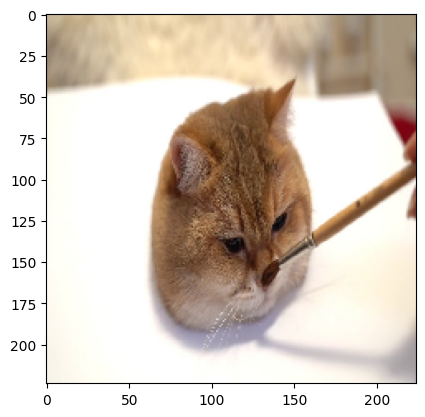

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt

model = ResNet50(weights='imagenet')

img_path = '/content/gdrive/MyDrive/42028/Week7/images/cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

VGG16 CNN architecture as the base mode. Adaptation /re-training of the FC layers to Dogs and Cats classification task.


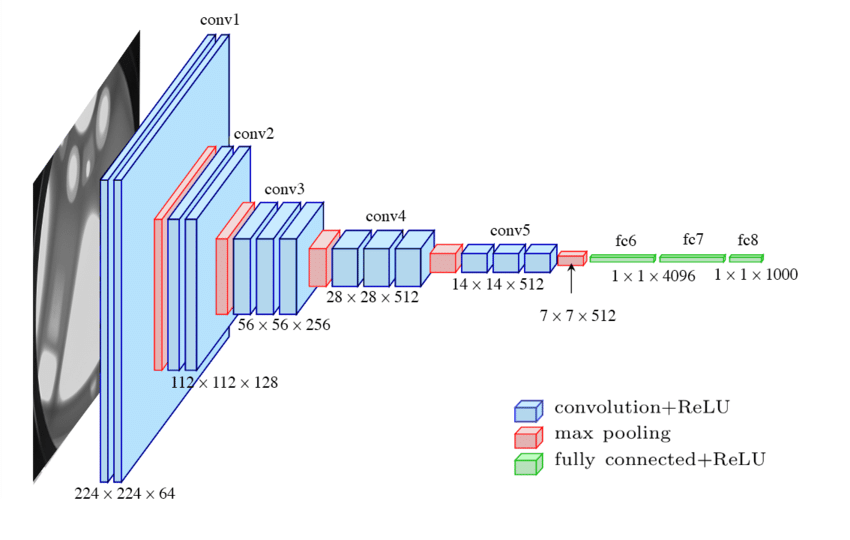

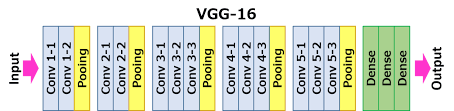

In [ ]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))


from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()
for layer in conv_base.layers[:-4]:
    layer.trainable = False
 
for layer in conv_base.layers:
    print(layer, layer.trainable)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


#### **Training**

In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150,150), 
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150,150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100, 
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50, 
      verbose=2)

Epoch 1/10
100/100 - 26s - loss: 0.5163 - acc: 0.7560 - val_loss: 0.3039 - val_acc: 0.8770 - 26s/epoch - 262ms/step
Epoch 2/10
100/100 - 22s - loss: 0.3204 - acc: 0.8625 - val_loss: 0.2578 - val_acc: 0.8850 - 22s/epoch - 217ms/step
Epoch 3/10
100/100 - 21s - loss: 0.2782 - acc: 0.8810 - val_loss: 0.2072 - val_acc: 0.9130 - 21s/epoch - 207ms/step
Epoch 4/10
100/100 - 20s - loss: 0.2450 - acc: 0.8960 - val_loss: 0.3004 - val_acc: 0.8790 - 20s/epoch - 198ms/step
Epoch 5/10
100/100 - 21s - loss: 0.2380 - acc: 0.9085 - val_loss: 0.5687 - val_acc: 0.8890 - 21s/epoch - 206ms/step
Epoch 6/10
100/100 - 20s - loss: 0.2300 - acc: 0.9090 - val_loss: 0.3268 - val_acc: 0.9010 - 20s/epoch - 196ms/step
Epoch 7/10
100/100 - 21s - loss: 0.2082 - acc: 0.9220 - val_loss: 0.1613 - val_acc: 0.9400 - 21s/epoch - 207ms/step
Epoch 8/10
100/100 - 21s - loss: 0.1710 - acc: 0.9325 - val_loss: 0.1689 - val_acc: 0.9390 - 21s/epoch - 208ms/step
Epoch 9/10
100/100 - 20s - loss: 0.1912 - acc: 0.9240 - val_loss: 0.2387

#### **Results** 

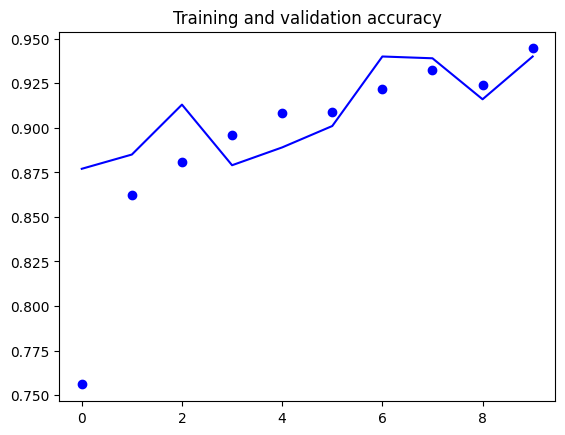

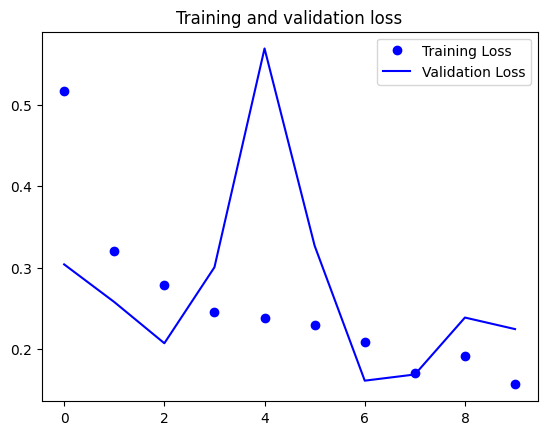

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### **AlexNet implementation**

Alexnet CNN architecture:

<!-- ![alt text](https://www.oreilly.com/api/v2/epubs/9781491980446/files/assets/tfdl_0106.png) -->
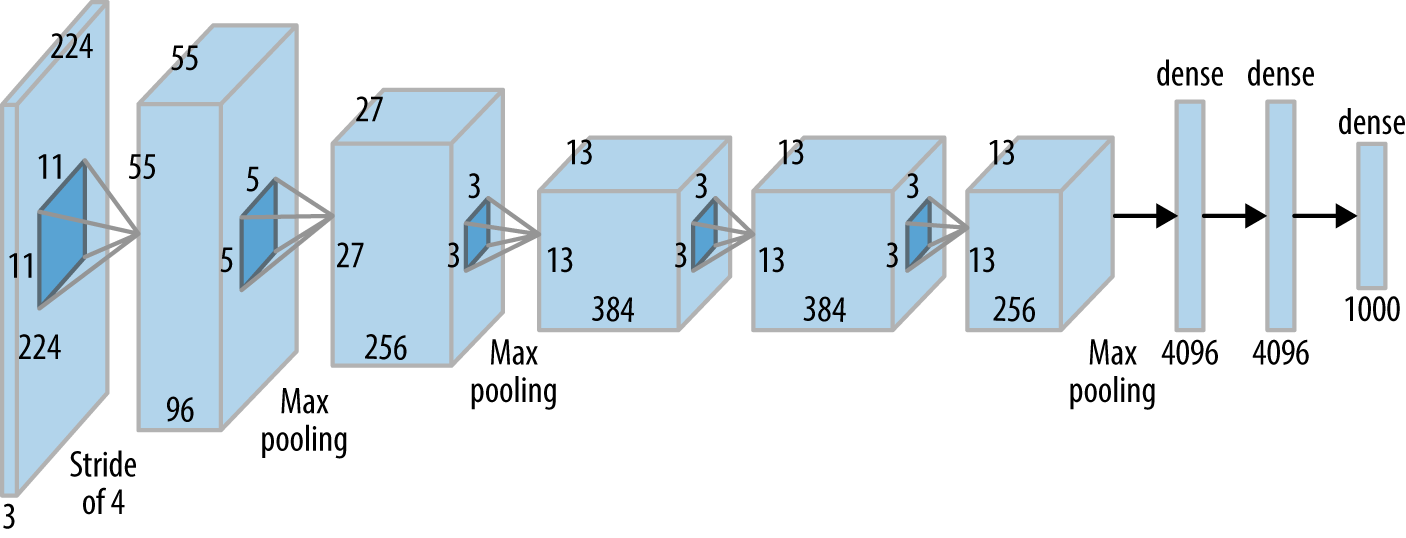

In [ ]:
model = tf.keras.models.Sequential([
    #Conv_1
    tf.keras.layers.Conv2D(96, (11,11),strides=4, padding='valid', activation='relu', input_shape=(224, 224, 3)),
    # Pooling_1
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='valid'),
    # Batch Normalisation_1
    tf.keras.layers.BatchNormalization(),
    # Conv_2
    tf.keras.layers.Conv2D(256, (5,5),strides=1, padding='valid', activation='relu'),
    # Pooling_2
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='valid'),
    #Batch Normalisation_2
    tf.keras.layers.BatchNormalization(),
    # Conv_3
    tf.keras.layers.Conv2D(384, (3,3),strides=1, padding='valid', activation='relu'),
    # Batch Normalisation_3
    tf.keras.layers.BatchNormalization(),
    # Conv_4
    tf.keras.layers.Conv2D(384, (3,3),strides=1, padding='valid', activation='relu'),
    # Batch Normalisation_3
    tf.keras.layers.BatchNormalization(),
    #conv_5
    tf.keras.layers.Conv2D(256, (3,3),strides=1, padding='valid', activation='relu'),
    #pooling_3
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2),padding='valid'),
    #Batch Normalization_4
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    #Dense layer_1
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    #Dense layer_2
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    #Dense layer_3
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])


In [ ]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(224,224),  
        batch_size=20,  
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224,224),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=10,
      verbose=2)

Epoch 1/20
100/100 - 34s - loss: 0.9139 - acc: 0.5400 - val_loss: 0.7430 - val_acc: 0.5150 - 34s/epoch - 336ms/step
Epoch 2/20
100/100 - 28s - loss: 0.8895 - acc: 0.5390 - val_loss: 0.8507 - val_acc: 0.5450 - 28s/epoch - 280ms/step
Epoch 3/20
100/100 - 28s - loss: 0.9282 - acc: 0.5200 - val_loss: 0.7485 - val_acc: 0.5300 - 28s/epoch - 277ms/step
Epoch 4/20
100/100 - 27s - loss: 0.8731 - acc: 0.5545 - val_loss: 0.7161 - val_acc: 0.5500 - 27s/epoch - 275ms/step
Epoch 5/20
100/100 - 28s - loss: 0.8609 - acc: 0.5450 - val_loss: 1.0734 - val_acc: 0.5250 - 28s/epoch - 279ms/step
Epoch 6/20
100/100 - 28s - loss: 0.8774 - acc: 0.5440 - val_loss: 0.8989 - val_acc: 0.5350 - 28s/epoch - 277ms/step
Epoch 7/20
100/100 - 28s - loss: 0.8536 - acc: 0.5430 - val_loss: 0.9603 - val_acc: 0.6150 - 28s/epoch - 281ms/step
Epoch 8/20
100/100 - 28s - loss: 0.8717 - acc: 0.5480 - val_loss: 0.7132 - val_acc: 0.6650 - 28s/epoch - 275ms/step
Epoch 9/20
100/100 - 27s - loss: 0.8448 - acc: 0.5430 - val_loss: 0.9394

#### **Results**

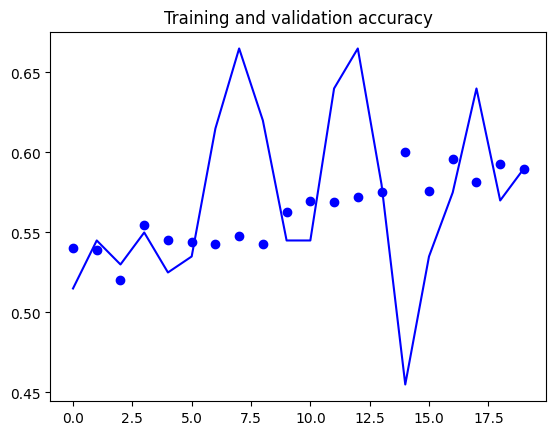

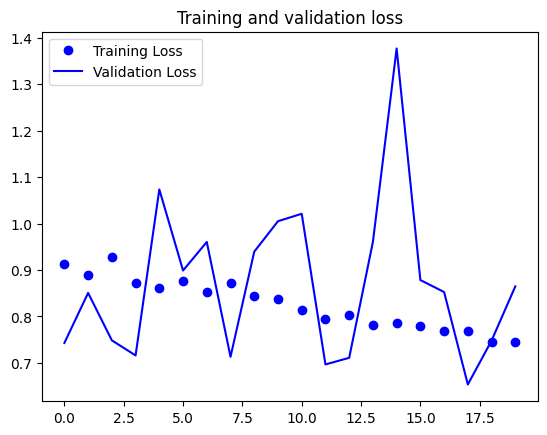

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()